# Импорты

In [1]:
import copy

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Константы

In [2]:
BUDGET = 10**10
PRICE = 450_000

# Функции

In [3]:
def rmse(y_true, y_pred):
    """
    На основе метрики sklearn.metrics.mean_squared_error рассчитывает метрику RMSE.
    """
    return mean_squared_error(y_true, y_pred) ** 0.5

In [4]:
def fit_predict_report(X_train, 
                       y_train, 
                       X_test, 
                       y_test,
                       model=LinearRegression(n_jobs=-1)):
    """
    Обучает модель model на признаках X_train и ответах y_train.
    Тестирует модель на валидационных данных X_test, y_test.
    Расчитывает и выводит на экран метрику качества модели RMSE на валидационных данных X_test, y_test.
    Выводит на экран диаграмму распределения предсказаний.
    """
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    print(f"Средний запас предсказанного сырья = {prediction.mean()}")
    print(f"RMSE = {rmse(y_test, prediction)}")

    sns.histplot(prediction)
    plt.title('Предсказанный объем сырья')
    plt.xlabel('тыс. баррелей сырья')
    plt.ylabel('Количество скважин')
    plt.show()
    
    try:
        print("Формула расчета объема нефти в скважине:")
        print(f'product = ({model.coef_[0]} * f0) + ({model.coef_[1]} * f1) + ({model.coef_[2]} * f2) + {model.intercept_}')
    except:
        pass
    
    return prediction, copy.deepcopy(model)

In [5]:
def calculate_profit(subsample):
    """
    Расчитывает прибыль, полученную из подвыбрки subsample при цене PRICE и бюджете BUDGET.
    Принимает объект типа pandas.DataFrame с обязательными столбцами product и prediction.
    Возвращает вещественное число.
    """
    result = (subsample
              .sort_values(by='prediction', 
                           ascending=False)
              .head(200)['product']
              .sum() * PRICE - BUDGET)
    return result

In [6]:
def bootstrap(region, n=1000, size=500):
    """
    Созадает n подвыборок размера size методом bootstrap, для каждой подвыборки считает прибыль.
    Возвращает объект типа pandas.Series - распределение прибыли.
    """
    state = np.random.RandomState(45)
    profit_dist = []
    for _ in range(n):
        subsample = region.sample(n=size, replace=True, random_state=state)
        profit_dist.append(calculate_profit(subsample))
    return pd.Series(profit_dist)

In [7]:
def report(region):
    """
    Выводит на экран отчет о прибыли с региона region.
    """
    print('Общая информация о прибыли с региона:')
    display(region.describe())
    
    sns.histplot(region)
    plt.title('Распределение средней прибыли с региона')
    plt.xlabel('руб.')
    plt.ylabel('Скважин')
    plt.show()
    
    print("С вероятностью 95% прибыль с региона будет в промежутке:")
    print(f"от {region.quantile(0.025):0.4f} до {region.quantile(0.975):0.4f} рублей")
    print()
    print(f'Средняя прибыль с региона: {region.mean():0.4f} рублей')
    print()
    risk_prob = len(region[region < 0]) / len(region)
    print(f'Вероятность получить убытки: {risk_prob:0.2%}')
    print()
    print('Итог:')
    if risk_prob > 0.025:
        print('Из-за больших рисков (>2,5%) этот регион не рекомендуется к разработке.')
    else:
        print('Вероятность убытков меньше 2,5%, поэтому рекомендуется выбрать данный регион для разработки.')

## Загрузка и подготовка данных

In [8]:
try:
    reg1_data = pd.read_csv('geo_data_0.csv')
    reg2_data = pd.read_csv('geo_data_1.csv')
    reg3_data = pd.read_csv('geo_data_2.csv')
except:
    reg1_data = pd.read_csv('/datasets/geo_data_0.csv')
    reg2_data = pd.read_csv('/datasets/geo_data_1.csv')
    reg3_data = pd.read_csv('/datasets/geo_data_2.csv')

### Первый регион

In [9]:
data = reg1_data
data.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропусков нет.

Проверим уникальность индексов.

In [11]:
data.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

Удалим не уникальные.

In [12]:
unique_ids = data.sort_values(by='product')['id'].drop_duplicates()
data = data.loc[unique_ids.index]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 57263 to 8826
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       99990 non-null  object 
 1   f0       99990 non-null  float64
 2   f1       99990 non-null  float64
 3   f2       99990 non-null  float64
 4   product  99990 non-null  float64
dtypes: float64(4), object(1)
memory usage: 4.6+ MB


**Итог:**  
Удалены дубликаты. Пропусков нет.

Удалим неинформативный признак `id`.

In [13]:
data = data.drop('id', axis=1)

Аналогичные манипуляции проведем с данными по остальным регионам.

Рассмотрим признаковое описание объектов - скважин.

In [14]:
data.describe()

,f0,f1,f2,product
count,99990.000000,99990.000000,99990.000000,99990.000000
mean,0.500426,0.250151,2.502544,92.497431
std,0.871854,0.504431,3.248126,44.289177
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072653,-0.200864,0.287784,56.495873
50%,0.502360,0.250252,2.515969,91.842960
75%,1.073626,0.700654,4.714970,128.562225
max,2.362331,1.343769,16.003790,185.364347


Судя по среднему и медиане перекоса признаков нет. Далее рассмотрим их распределение.  
Отрицательных значений объемов сырья также не наблюдается.

Рассмотрим линейную корреляцию признаков.

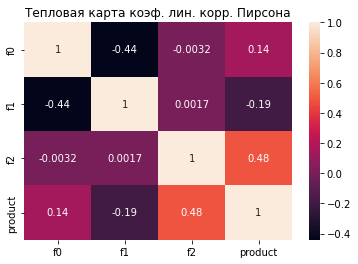

In [15]:
sns.heatmap(data.corr(), annot=True)
plt.title('Тепловая карта коэф. лин. корр. Пирсона')
plt.show()

`f2` наиболее коррелирован с `product`.  
У `f1` наблюдается небольшая отрицательная корреляция. `f0` коррелирует слабее всех.

Рассмотрим попарное распределение признаков.

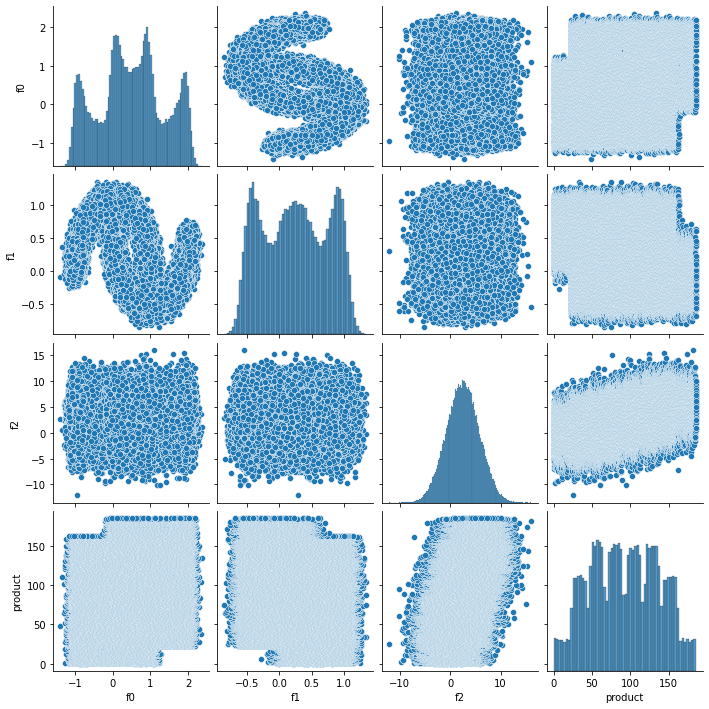

In [16]:
sns.pairplot(data);

`f2` распределен нормально. `f1` и `f0` и `product` имеют многомодальное распределение.

In [17]:
X1 = data.drop('product', axis=1)
y1 = data['product']

### Второй регион

In [18]:
data = reg2_data
unique_ids = data.sort_values(by='product')['id'].drop_duplicates()
data = data.loc[unique_ids.index]
data = data.drop('id', axis=1)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 49999 to 27985
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,1.141040,-4.796625,2.494481,68.823409
std,8.965783,5.119897,1.703573,45.944494
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.152033,-4.813172,2.011470,57.085625
75%,8.620875,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


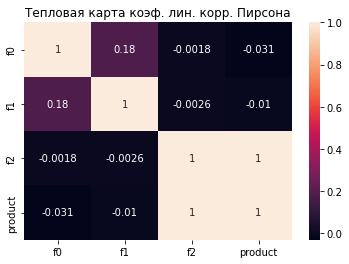

In [19]:
sns.heatmap(data.corr(), annot=True)
plt.title('Тепловая карта коэф. лин. корр. Пирсона')
plt.show()

`f0` и `f1`не скоррелированны с таргетом. `f2` линейно зависим. `f1` достаточно высоко скоррелирован с `f0`.

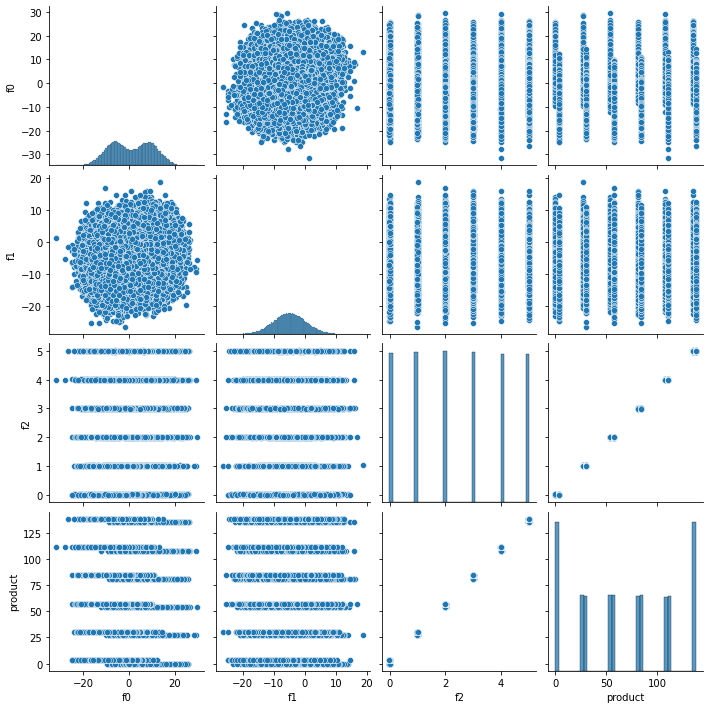

In [20]:
sns.pairplot(data);

`f2` почти дискретный, принимает значения от 0 до 5. `f1` - нормальное распределение, `f0` - бимодальное. `product` также почти дискретный.

In [21]:
X2= data.drop('product', axis=1)
y2= data['product']

### Третий регион

In [22]:
data = reg3_data
tmp = data.sort_values(by='product')['id'].drop_duplicates()
data = data.loc[tmp.index]
data = data.drop('id', axis=1)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 68149 to 79705
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


,f0,f1,f2,product
count,99996.000000,99996.000000,99996.000000,99996.000000
mean,0.002010,-0.002100,2.495046,94.997431
std,1.732056,1.730390,3.473469,44.748717
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130269,59.450028
50%,0.009424,-0.009482,2.484188,94.917850
75%,1.158477,1.163592,4.858662,130.585544
max,7.238262,7.844801,16.739402,190.029838


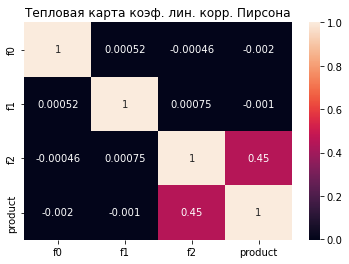

In [23]:
sns.heatmap(data.corr(), annot=True);
plt.title('Тепловая карта коэф. лин. корр. Пирсона')
plt.show()

`f0` и `f1` не скоррелированы с целевым признаком. `f2` имеет высокую положительную корреляцию.

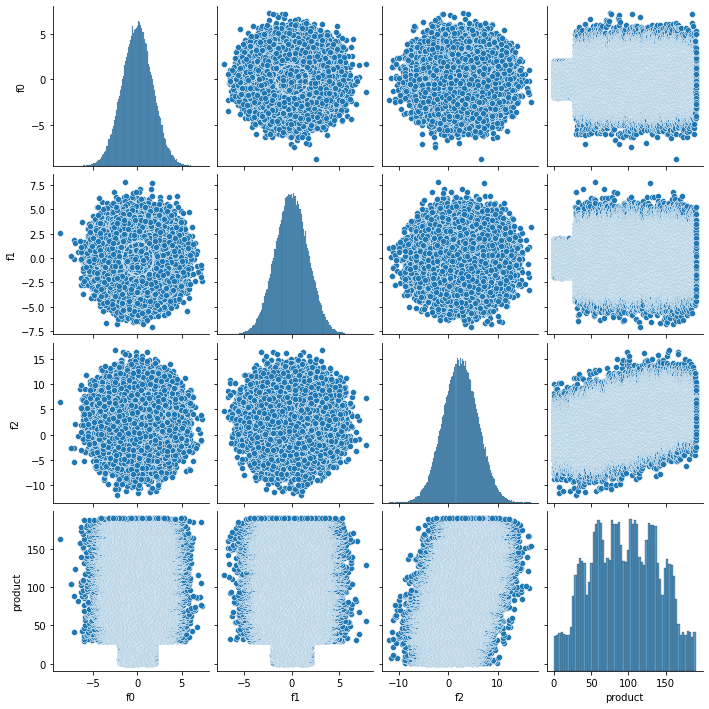

In [24]:
sns.pairplot(data);

Все три признака распределены нормально. Таргет - многомодальный.

In [25]:
X3 = data.drop('product', axis=1)
y3 = data['product']

Подготовим данные к обучению и тестированию моделей.

In [26]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state=45)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=45)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25, random_state=45)

scaler = StandardScaler()

X1_train = scaler.fit_transform(X1_train)
X1_test = scaler.transform(X1_test)

X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

X2_train = scaler.fit_transform(X2_train)
X2_test = scaler.transform(X2_test)

## Обучение и проверка модели

### Первый район - предсказание

Средний запас предсказанного сырья = 92.51305407777295
RMSE = 37.69852271950747


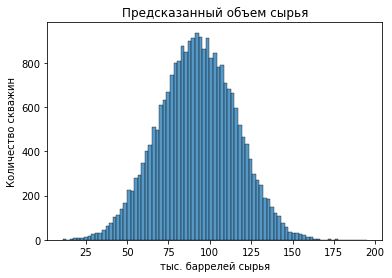

Формула расчета объема нефти в скважине:
product = (3.2177961323970363 * f0) + (-7.144017261626477 * f1) + (21.439548195623363 * f2) + 92.52769656587472


In [27]:
pred_1, linreg_1 = fit_predict_report(X1_train, y1_train, X1_test, y1_test)

Сравним предсказанные значения с исходными.

In [28]:
print(f"Среднее: {reg1_data['product'].mean()}, стандартное отклонение: {reg1_data['product'].std()}")

Среднее: 92.49999999999974, стандартное отклонение: 44.28869113685337


Среднее предсказание приблизительно равно среднему значению в исходном наборе данных. Метрика качества модели RMSE меньше, чем стандартное отклонение исходных данных. Распределение прогноза - нормальное, в то время как исходное распределение - многомодальное. Это обуславливается выбранной моделью машинного обучения.

### Второй район - предсказание

Средний запас предсказанного сырья = 68.51661188409523
RMSE = 0.8892643125096581


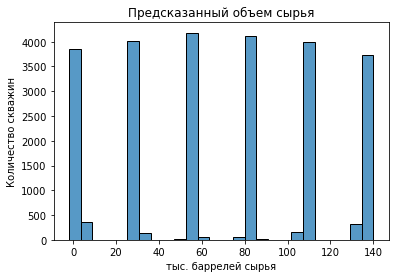

Формула расчета объема нефти в скважине:
product = (-1.2987086719297918 * f0) + (-0.1122809454883909 * f1) + (45.92468345796971 * f2) + 68.9223780457462


In [29]:
pred_2, linreg_2 = fit_predict_report(X2_train, y2_train, X2_test, y2_test)

In [30]:
print(f"Среднее: {reg2_data['product'].mean()}, стандартное отклонение: {reg2_data['product'].std()}")

Среднее: 68.82500000002561, стандартное отклонение: 45.944422894970224


Средние приблизительно равны. Получилось достаточно маленькая ошибка. Это обусловленно тем, что `f2` и `product` в этом регионе имеют коэффициент линейной корреляции приблизительно равный единице, поэтому линейная модель очень точно восстановила зависимость.

### Третий район - предсказание

Средний запас предсказанного сырья = 95.15001488440087
RMSE = 40.17051067532765


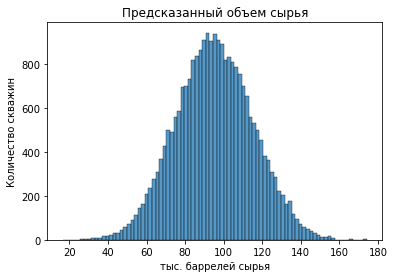

Формула расчета объема нефти в скважине:
product = (-0.08828772507241689 * f0) + (-0.022929258824840204 * f1) + (5.756352542417787 * f2) + 80.7383928982525


In [31]:
pred_3, linreg_3 = fit_predict_report(X3_train, y3_train, X3_test, y3_test)

In [32]:
print(f"Среднее: {reg3_data['product'].mean()}, стандартное отклонение: {reg3_data['product'].std()}")

Среднее: 95.00000000000041, стандартное отклонение: 44.74992106895222


Результат аналогичен первому региону:  
RMSE меньше стандартного отклонения.  
Средние приблизительно равны.  
Распределения не совпадают.

### ИТОГИ

1) `linreg_1`, `linreg_2`, `linreg_3` - обученные линейные модели.  
2) `pred_1..3` - предсказания на валидационной выборке.  
3) `y1..3_test` - реальные значения на валидационной выборке.

## Подготовка к расчёту прибыли

In [33]:
region_1 = pd.DataFrame(y1_test)
region_1['prediction'] = pred_1

region_2 = pd.DataFrame(y2_test)
region_2['prediction'] = pred_2

region_3 = pd.DataFrame(y3_test)
region_3['prediction'] = pred_3

region_1.head()

,product,prediction
24484,54.830622,94.470520
63317,58.338316,76.959389
76731,148.142864,84.097500
13088,60.807972,89.055376
34651,139.306631,85.468348


Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [34]:
region_no_loss = BUDGET / 200 / PRICE
print(f'Необходимый объем нефти для безубыточной разработки: {region_no_loss:0.3f} тыс. баррелей')

Необходимый объем нефти для безубыточной разработки: 111.111 тыс. баррелей


Это значение больше среднего для всех трех регионов.

**ВЫВОД:**  
В первом и третьем регионе нужно выбирать скважины, запасы нефти в которых лежат между медианой и максимумом. Во втором регионе подойдут только скважины, в которых запасов нефти больше, чем 75% остальных скважинах.

## Расчёт прибыли и рисков 

### Bootstrap

In [35]:
reg_1_profit_dist = bootstrap(region_1)
reg_2_profit_dist = bootstrap(region_2)
reg_3_profit_dist = bootstrap(region_3)

### Первый регион

Общая информация о прибыли с региона:


count    1.000000e+03
mean     4.265491e+08
std      2.621350e+08
min     -6.122660e+08
25%      2.616179e+08
50%      4.364540e+08
75%      6.108043e+08
max      1.168325e+09
dtype: float64

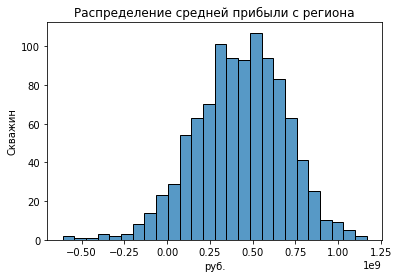

С вероятностью 95% прибыль с региона будет в промежутке:
от -114309439.1792 до 897558391.7421 рублей

Средняя прибыль с региона: 426549134.3151 рублей

Вероятность получить убытки: 5.60%

Итог:
Из-за больших рисков (>2,5%) этот регион не рекомендуется к разработке.


In [36]:
report(reg_1_profit_dist)

### Второй регион

Общая информация о прибыли с региона:


count    1.000000e+03
mean     4.209007e+08
std      2.082607e+08
min     -1.922059e+08
25%      2.823944e+08
50%      4.203069e+08
75%      5.654658e+08
max      1.196157e+09
dtype: float64

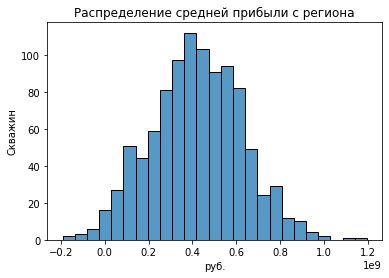

С вероятностью 95% прибыль с региона будет в промежутке:
от 26000435.3762 до 829445010.1460 рублей

Средняя прибыль с региона: 420900707.2611 рублей

Вероятность получить убытки: 1.50%

Итог:
Вероятность убытков меньше 2,5%, поэтому рекомендуется выбрать данный регион для разработки.


In [37]:
report(reg_2_profit_dist)

### Третий регион

Общая информация о прибыли с региона:


count    1.000000e+03
mean     3.554846e+08
std      2.724479e+08
min     -5.075279e+08
25%      1.645012e+08
50%      3.516108e+08
75%      5.471479e+08
max      1.165883e+09
dtype: float64

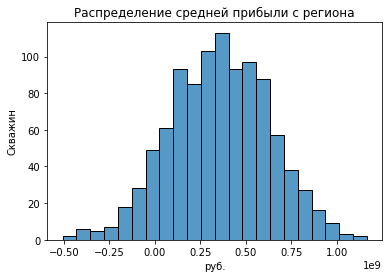

С вероятностью 95% прибыль с региона будет в промежутке:
от -175366033.1235 до 878865232.6043 рублей

Средняя прибыль с региона: 355484554.5330 рублей

Вероятность получить убытки: 10.10%

Итог:
Из-за больших рисков (>2,5%) этот регион не рекомендуется к разработке.


In [38]:
report(reg_3_profit_dist)

## Вывод

По результатам исследования рекомендуется выбрать для разработки регион №2, потому что только для этого региона риски убытков оказались меньше 2,5%.  
  
Результат может показаться достаточно неожиданным, потому что средние запасы нефти в этом регионе наименьшие. Но в силу точности предсказания (модель в среднем ошибалсь менее чем на 1 тысячу баррелей), были выбраны наилучшие скважины для разработки, поэтому удалось максимизировать прибыль.  
  
Также перспективным для разработки выглядит регион №1, потому что средняя прибыль там выше, чем во втором регионе. Средние запасы продукта также выше. Если удастся поднять точность модели так, что риски уменьшаться ниже порога (2,5%), этот регион станет более выгодным для разработки.  
  
Третий регион является наиболее рискованным, и наименее прибыльным. Предположу, что это связано c большой зашумленностью данных. Среднее, медиана и 0.75-ый квантиль для этого региона похожи на значения первого региона и значительно выше значений второго, но модель ошибается сильнее.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован